In [16]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.stats
%run Rich_Interactions_in_MR\plot_gesture_log.py

In [17]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Sequence Decoding for Hand Gesture Recognition

Hand gestures offer an immersive and intuitive interaction method for various applications in Mixed Reality (MR). Modern MR headsets provide fairly accurate dynamic hand skeleton data which helps to both standardise and streamline the development of gesture recognition functionality. Ideally, developers should then be able to integrate robust custom gesture recognition functionality into their applications with little effort.

There have been efforts to streamline the process of developing custom gesture recognition functionality for use in virtual and augmented reality applications (see, for example, [Mo et al.](https://doi.org/10.1145/3411764.3445766) and [Shen et al.](https://doi.org/10.1109/TVCG.2022.3203004)). The Meta Quest SDK also now offers some [Hand Pose Detection](https://developer.oculus.com/documentation/unity/unity-isdk-hand-pose-detection) functionality. One lightweight approach that is suitable for small and carefully designed hand gesture sets involves separately recognising and aggregating individual finger movements. A key advantage of this approach is that recognition functionality can be developed via a syntax describing the sequence of separate finger movements rather than being data driven. This can help to reduce the need for training data, and deliver more interpretable recognition behaviour.

We can frame this per-finger classification and aggregation task as a sequence decoding problem. We have a set of observations for each finger from the hand tracking data stream, $O = \left\{o^{(1)}, o^{(2)}, o^{(3)}, o^{(4)}, o^{(5)}\right\}$ and we wish to find a _hypothesis_ for $O$, which is a corresponding set of intended finger states ${S} = \left\{s^{(1)}, s^{(2)}, s^{(3)}, s^{(4)}, s^{(5)}\right\}$. For now, let's assume we are just working with a single hand and so there are only five possible obseverations and five possible intended states at a given instance in time. For simplicity we ignore the _prior_, $P(S)$, but this could be incorporated if we had some sense of the expected distribution of finger states within our gesture set.

Although the approach can be applied to larger gesture sets, for the sake of this tutorial we will focus on the task of discriminating between three well-established hand gestures: Scissors, Paper and Rock.

<table>
<tr>
    <td> <img src='./Rich_Interactions_in_MR/imgs/scissors_render.png' style="width: 250px;"/> </td>
    <td> <img src='./Rich_Interactions_in_MR/imgs/paper_render.png' style="width: 250px;"/> </td>
    <td> <img src='./Rich_Interactions_in_MR/imgs/rock_render.png' style="width: 250px;"/> </td>
</tr>
<tr>
    <td style="text-align: center">Scissors</td>
    <td style="text-align: center">Paper</td>
    <td style="text-align: center">Rock</td>
</tr>
</table>

## Hand Tracking

As mentioned above, modern VR and augmented reality (AR) headsets provide native hand tracking. The hand tracking data is available in the form of 'skeleton joints'. Within the WebXR framework, each hand is made up of 25 joints as shown below. This image comes from the 'WebXR Hand Input Module - Level 1' W3C Working Draft. 

<img src='https://www.w3.org/TR/webxr-hand-input-1/images/hand-layout.svg'/>

This data gives the position and orientation of all the joints in the hand. You can plot individual frames of example log data below.

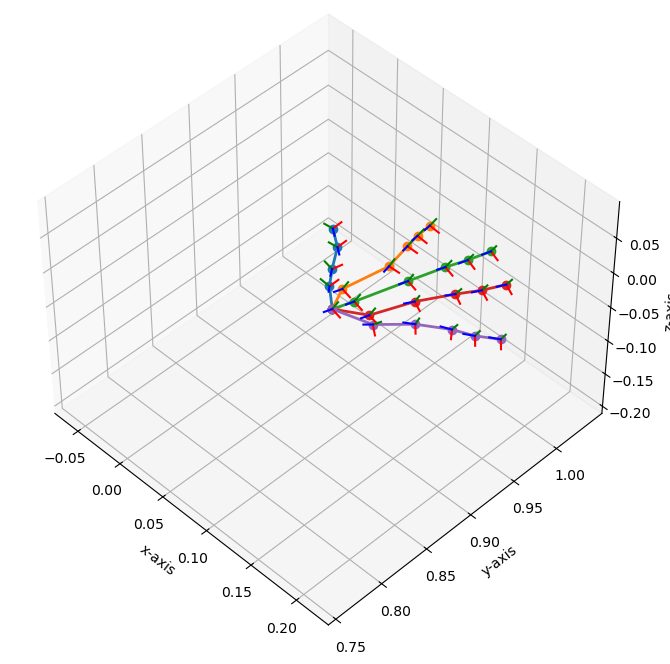

In [4]:
# log_frames = np.loadtxt('Rich_Interactions_in_MR/logs/scissors_log_example.csv', skiprows=1, delimiter=',')
log_frames = np.loadtxt('Rich_Interactions_in_MR/logs/paper_log_example.csv', skiprows=1, delimiter=',')
# log_frames = np.loadtxt('Rich_Interactions_in_MR/logs/rock_log_example.csv', skiprows=1, delimiter=',')

plot_gesture_log(log_frames, 200)

<div class="alert alert-info">
<strong>GROUP DISCUSSION:</strong> 
<ul>
    <li>
        Run GestureIndexer.py in 'Rich_Interactions_in_MR/logs/'. Look at the three different log files by modifying the final line.
    </li>
    <li>
        How distinct are the gestures?
    </li>
    <li>
        How might you go about classifying these gestures?
    </li>
</ul>
</div>

## Dataset

In this tutorial we make use of a dataset (awaiting publication!) containing approximately 10 demonstrations per gesture as perfomed by 20 unique participants. To give some structure to our analysis, let's split our dataset into 'training' and 'testing' subsets. We are most interested in how the approaches we investigate will generalise to new participants. In other words, we want to be confident that our approaches work on people who are using the system for the first time. Therefore we split at a 60:40 ratio on participants, giving 12 participants for 'training' and 8 participants for 'testing'.

Here is the arbitrary split on participants IDs we use going forward:
* Training:  8,  9, 10, 2, 12, 13, 14, 15, 18, 21, 22, 16,  
* Testing: 5, 6, 11, 23, 24, 17, 19, 20

## Decoding with Simple Thresholds on Bend Angles

The Scissors, Paper and Rock gesture set is a convenient example since all three gestures are very easy to discriminate based on the individual finger states. If we treat a finger as simply being either Bent or Unbent, we can approximately define each gesture using the following syntax.

| Gesture                                               | Thumb | Index | Middle | Ring | Pinky |
|:------------------------------------------------------|:--|:--|:--|:--|:--|
| Scissors                                              | B | U | U | B | B |
| Paper                                                 | U | U | U | U | U |
| Rock                                                  | B | B | B | B | B |

We can describe how 'bent' a finger is by the total bend angle, with respect to the main axis of rotation for that joint, over all joints for that finger. The csv file loaded in the following cell contains the post-processed total bend angles of each finger for each gesture. Note that the following plots are based just on the 'training' subset participants.

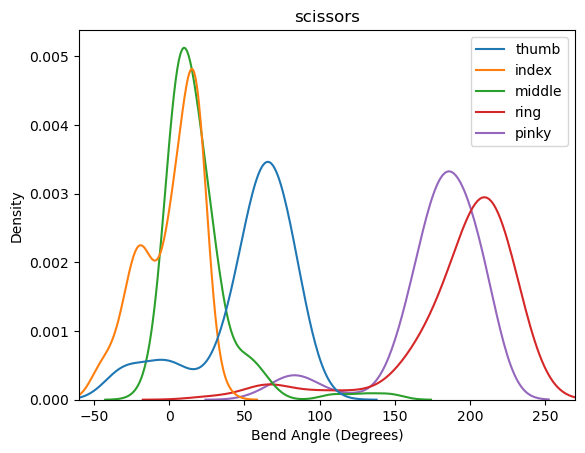

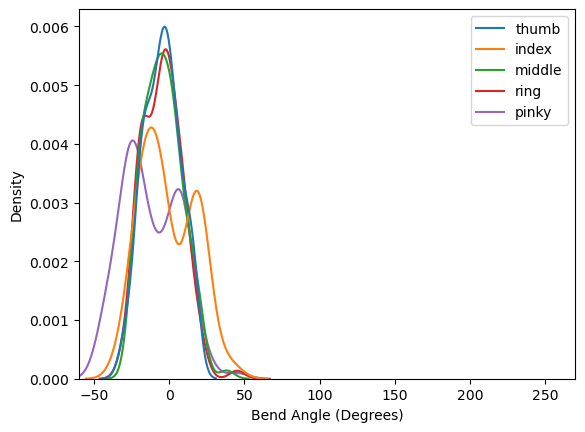

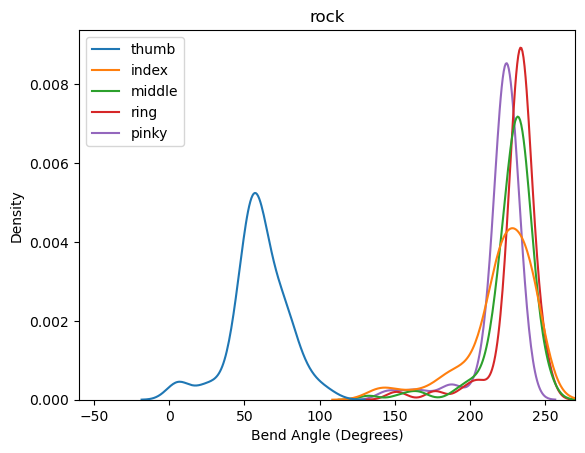

In [9]:
bend_angles = pd.read_csv('Rich_Interactions_in_MR/logs/processed_bend_angles.csv', header=None, names=['pid', 'lid', 'gesture', 'thumb', 'index', 'middle', 'ring', 'pinky']) 

# Pull out training subset
training_set = bend_angles[(bend_angles["pid"].isin([ 8, 9, 10, 2, 12, 13, 14, 15, 18, 21, 22, 16]))]

ax1 = sns.kdeplot(training_set[training_set["gesture"] == 'scissors'][["thumb", "index", "middle", "ring", "pinky"]])
ax1.set(xlabel='Bend Angle (Degrees)');
ax1.set_xlim(-60, 270)
ax1.set_title('scissors')
plt.show()

ax2 = sns.kdeplot(training_set[training_set["gesture"] == 'paper'][["thumb", "index", "middle", "ring", "pinky"]])
ax2.set(xlabel='Bend Angle (Degrees)');
ax2.set_xlim(-60, 270)
ax2.set_title('paper')
plt.show()

ax3 = sns.kdeplot(training_set[training_set["gesture"] == 'rock'][["thumb", "index", "middle", "ring", "pinky"]])
ax3.set(xlabel='Bend Angle (Degrees)');
ax3.set_xlim(-60, 270)
ax3.set_title('rock')
plt.show()

<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise 3</h3> 
<br>
Decide on a single bent/unbent threshold value to classify the finger states and recognise gestures.
</div>
</p>

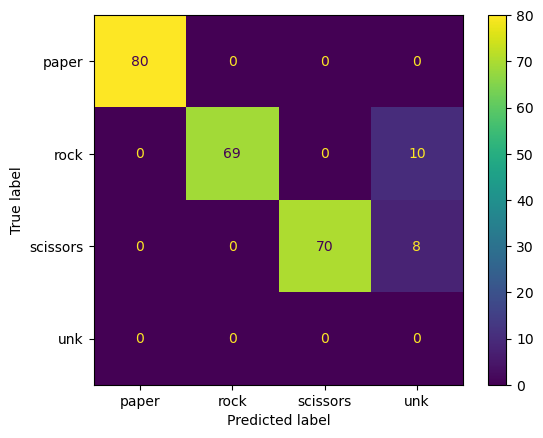

In [12]:
bend_angles = pd.read_csv('Rich_Interactions_in_MR/logs/processed_bend_angles.csv', header=None, names=['pid', 'lid', 'gesture', 'thumb', 'index', 'middle', 'ring', 'pinky']) 

# Pull out test subset
test_set = bend_angles[~(bend_angles["pid"].isin([ 8, 9, 10, 2, 12, 13, 14, 15, 18, 21, 22, 16]))]

# True labels
y_true = test_set["gesture"].tolist()
y_pred = []

# What should this threshold be?
theta_thr = 50;

for i in range(test_set.shape[0]):    
    f_labels = ["X","X","X","X","X"]
    g_data = test_set.iloc[i]
    
    # Evaluate finger states
    f_labels[0] = "U" if g_data["thumb"] < theta_thr else "B"
    f_labels[1] = "U" if g_data["index"] < theta_thr else "B"
    f_labels[2] = "U" if g_data["middle"] < theta_thr else "B"
    f_labels[3] = "U" if g_data["ring"] < theta_thr else "B"
    f_labels[4] = "U" if g_data["pinky"] < theta_thr else "B"
    
    g_pose = ''.join(f_labels)
    g_label = 'unk'
    
    if g_pose == "BUUBB":
        g_label = 'scissors'
    elif g_pose == "UUUUU":
        g_label = 'paper'
    elif g_pose == "BBBBB":
        g_label = 'rock'    
    
    y_pred.append(g_label)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['paper','rock','scissors','unk'])
disp.plot()
plt.show()

## Probabilistic Finger States

This works suprsingly well, but can we do better? What about a probabilistic classification of the bent/unbent state of a finger?

Let's look at how distinct the two figners states are across the fingers for all gestures.

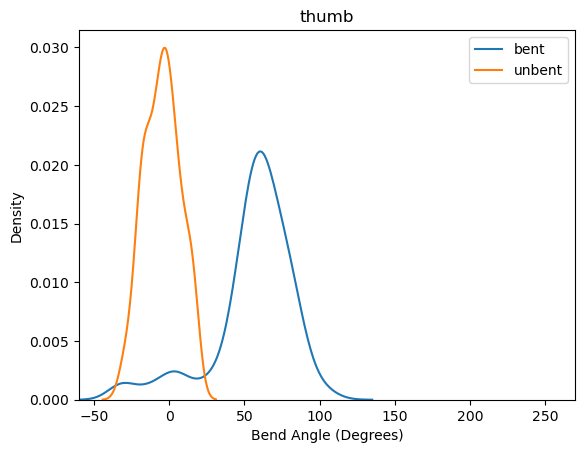

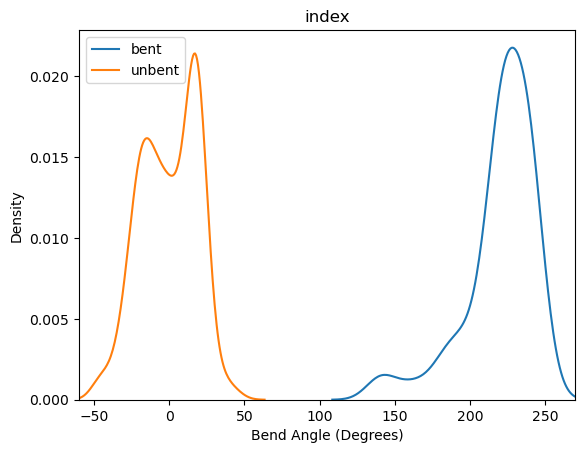

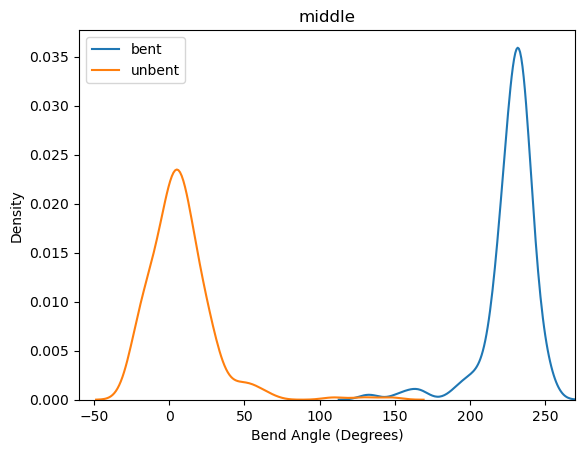

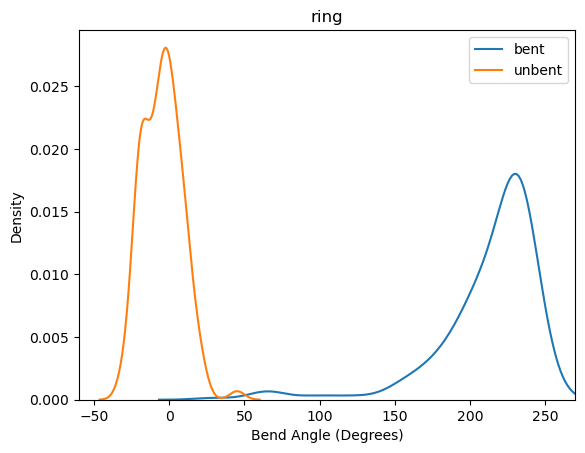

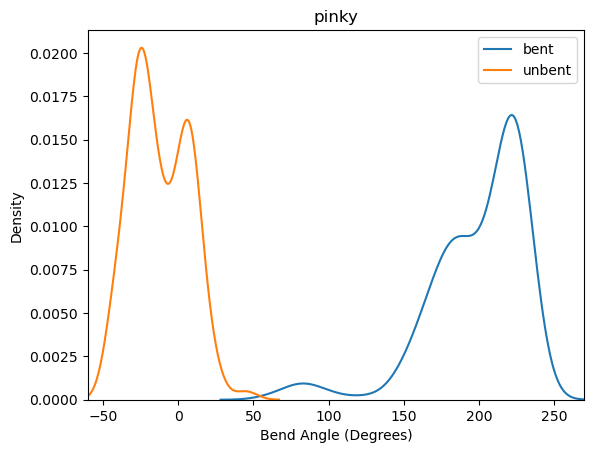

In [13]:
bend_angles = pd.read_csv('Rich_Interactions_in_MR/logs/processed_bend_angles.csv', header=None, names=['pid', 'lid', 'gesture', 'thumb', 'index', 'middle', 'ring', 'pinky']) 

# Pull out training subset
training_set = bend_angles[(bend_angles["pid"].isin([ 8, 9, 10, 2, 12, 13, 14, 15, 18, 21, 22, 16]))]

# Thumb
thumb_bent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'rock')]["thumb"]
thumb_unbent = training_set[training_set["gesture"] == 'paper']["thumb"]
ax_thumb = sns.kdeplot(thumb_bent,label='bent')
ax_thumb = sns.kdeplot(thumb_unbent,label='unbent')
ax_thumb.set(xlabel='Bend Angle (Degrees)');
ax_thumb.set_xlim(-60, 270)
ax_thumb.set_title('thumb')
ax_thumb.legend()
plt.show()

# Index
index_unbent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'paper')]["index"]
index_bent = training_set[training_set["gesture"] == 'rock']["index"]
ax_index = sns.kdeplot(index_bent,label='bent')
ax_index = sns.kdeplot(index_unbent,label='unbent')
ax_index.set(xlabel='Bend Angle (Degrees)');
ax_index.set_xlim(-60, 270)
ax_index.set_title('index')
ax_index.legend()
plt.show()

# Middle
middle_unbent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'paper')]["middle"]
middle_bent = training_set[training_set["gesture"] == 'rock']["middle"]
ax_middle = sns.kdeplot(middle_bent,label='bent')
ax_middle = sns.kdeplot(middle_unbent,label='unbent')
ax_middle.set(xlabel='Bend Angle (Degrees)');
ax_middle.set_xlim(-60, 270)
ax_middle.set_title('middle')
ax_middle.legend()
plt.show()

# Ring
ring_bent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'rock')]["ring"]
ring_unbent = training_set[training_set["gesture"] == 'paper']["ring"]
ax_ring = sns.kdeplot(ring_bent,label='bent')
ax_ring = sns.kdeplot(ring_unbent,label='unbent')
ax_ring.set(xlabel='Bend Angle (Degrees)');
ax_ring.set_xlim(-60, 270)
ax_ring.set_title('ring')
ax_ring.legend()
plt.show()

# Pinky
pinky_bent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'rock')]["pinky"]
pinky_unbent = training_set[training_set["gesture"] == 'paper']["pinky"]
ax_pinky = sns.kdeplot(pinky_bent,label='bent')
ax_pinky = sns.kdeplot(pinky_unbent,label='unbent')
ax_pinky.set(xlabel='Bend Angle (Degrees)');
ax_pinky.set_xlim(-60, 270)
ax_pinky.set_title('pinky')
ax_pinky.legend()
plt.show()



<p>
<div class="alert alert-block alert-success"> 
<h3>Exercise 4</h3> 
<br>
Classify finger states and recognise gestures using a probabilistic approach.
<br>
If you get this done quickly, explore different training:test participant allocations.
</div>
</p>

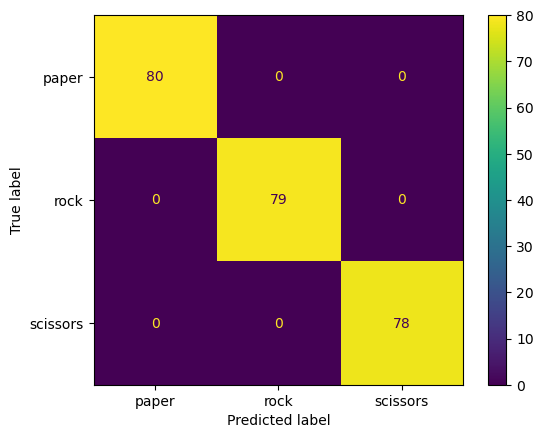

In [54]:
bend_angles = pd.read_csv('Rich_Interactions_in_MR/logs/processed_bend_angles.csv', header=None, names=['pid', 'lid', 'gesture', 'thumb', 'index', 'middle', 'ring', 'pinky']) 

# Pull out test subset
test_set = bend_angles[~(bend_angles["pid"].isin([ 8, 9, 10, 2, 12, 13, 14, 15, 18, 21, 22, 16]))]

# Pull out training subset
training_set = bend_angles[(bend_angles["pid"].isin([ 8, 9, 10, 2, 12, 13, 14, 15, 18, 21, 22, 16]))]

# Split into finger bent/straight data
thumb_bent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'rock')]["thumb"]
thumb_unbent = training_set[training_set["gesture"] == 'paper']["thumb"]
index_unbent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'paper')]["index"]
index_bent = training_set[training_set["gesture"] == 'rock']["index"]
middle_unbent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'paper')]["middle"]
middle_bent = training_set[training_set["gesture"] == 'rock']["middle"]
ring_bent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'rock')]["ring"]
ring_unbent = training_set[training_set["gesture"] == 'paper']["ring"]
pinky_bent = training_set[(training_set["gesture"] == 'scissors') | (training_set["gesture"] == 'rock')]["pinky"]
pinky_unbent = training_set[training_set["gesture"] == 'paper']["pinky"]

# True labels
y_true = test_set["gesture"].tolist()
y_pred = []

# What should this threshold be?
theta_thr = 42;

for i in range(test_set.shape[0]):    
    f_labels = ["X","X","X","X","X"]
    g_data = test_set.iloc[i]
    
    # Compute state probs
    prob_thumb_b = scipy.stats.norm(thumb_bent.mean(), thumb_bent.std()).pdf(g_data["thumb"])
    prob_thumb_u = scipy.stats.norm(thumb_unbent.mean(), thumb_unbent.std()).pdf(g_data["thumb"])
    prob_index_b = scipy.stats.norm(index_bent.mean(), index_bent.std()).pdf(g_data["index"])
    prob_index_u = scipy.stats.norm(index_unbent.mean(), index_unbent.std()).pdf(g_data["index"])
    prob_middle_b = scipy.stats.norm(middle_bent.mean(), middle_bent.std()).pdf(g_data["middle"])
    prob_middle_u = scipy.stats.norm(middle_unbent.mean(), middle_unbent.std()).pdf(g_data["middle"])
    prob_ring_b = scipy.stats.norm(ring_bent.mean(), ring_bent.std()).pdf(g_data["ring"])
    prob_ring_u = scipy.stats.norm(ring_unbent.mean(), ring_unbent.std()).pdf(g_data["ring"])
    prob_pinky_b = scipy.stats.norm(pinky_bent.mean(), pinky_bent.std()).pdf(g_data["pinky"])
    prob_pinky_u = scipy.stats.norm(pinky_unbent.mean(), pinky_unbent.std()).pdf(g_data["pinky"])
    
    # TODO
    # ...
    scissors_prob = 0
    paper_prob = 0
    rock_prob = 0
    
    # Create a numpy array with the estimated joint probs
    g_pose_probs = np.array([scissors_prob, paper_prob, rock_prob])
    
    g_label = 'unk'
    g_ind = np.argmax(g_pose_probs)
    
    if g_ind == 0:
        g_label = 'scissors'
    elif g_ind == 1:
        g_label = 'paper'
    elif g_ind == 2:
        g_label = 'rock'    
    
    y_pred.append(g_label)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['paper','rock','scissors'])
disp.plot()
plt.show()

# Offline versus Online Recognition

Our lightweight scissors-paper-rock recogniser works very well! However, robustly recognising hand gestures in an application setting is much more complicated. This tutorial gives an example of _offline_ recognition where we have a single frame of data (representing a single point in time). In practice, we would have a continuous stream of hand data requiring _online_ recognition. This adds several complications. Two major challenges are identifying unqiue gesture events, and ignoring hand movements where no gesture is intended. This is beyond the scope of the tutorial but if there is time let's have a briefy discussion.

<div class="alert alert-info">
<strong>GROUP DISCUSSION:</strong> 
<ul>
    <li>
        The recogniser developed gives an answer at every frame. What might we add to just fire an event when the gesture is first peformed?
    </li>
    <li>
        People move their hands around a lot. How might you prevent false activations?
    </li>
</ul>
</div>